# Twitter Sentiment Analysis

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

    100% |████████████████████████████████| 24.2MB 2.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: keras in /opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg (2.2.4)
You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 10.1MB 5.3MB/s 
  Found existing installation: pandas 0.23.4
    Uninstalling pandas-0.23.4:
      Successfully uninstalled pandas-0.23.4
You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [5]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/training.1600000.processed.noemoticon.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

TypeError: __init__() got an unexpected keyword argument 'max_rows'

   target                        ...                                                                       text
0       0                        ...                          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0                        ...                          is upset that he can't update his Facebook by ...
2       0                        ...                          @Kenichan I dived many times for the ball. Man...
3       0                        ...                            my whole body feels itchy and like its on fire 
4       0                        ...                          @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 584 ms, sys: 16 ms, total: 600 ms
Wall time: 602 ms


Text(0.5,1,'Dataset labels distribuition')

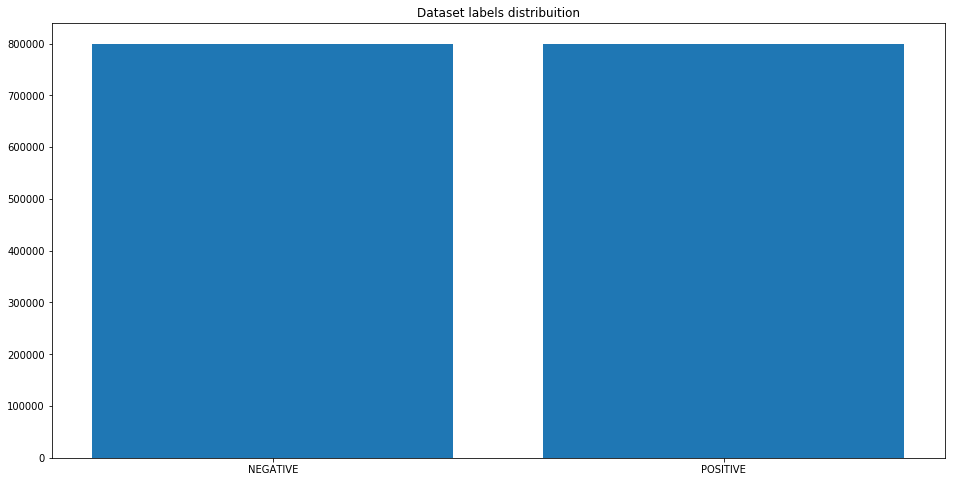

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(list(target_cnt.keys()), list(target_cnt.values()))
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 50.1 s, sys: 172 ms, total: 50.3 s
Wall time: 50.3 s


### Split train and test

In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.94 s, sys: 252 ms, total: 3.19 s
Wall time: 3.19 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

2019-02-17 04:49:27,381 : INFO : collecting all words and their counts
2019-02-17 04:49:27,382 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-17 04:49:27,404 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-02-17 04:49:27,425 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-02-17 04:49:27,445 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-02-17 04:49:27,468 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-02-17 04:49:27,492 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-02-17 04:49:27,517 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-02-17 04:49:27,540 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-02-17 04:49:27,561 : INFO : PROGRESS: at s

In [18]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-02-17 04:49:31,547 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-02-17 04:49:32,562 : INFO : EPOCH 1 - PROGRESS: at 4.56% examples, 372151 words/s, in_qsize 15, out_qsize 0
2019-02-17 04:49:33,590 : INFO : EPOCH 1 - PROGRESS: at 9.77% examples, 394537 words/s, in_qsize 15, out_qsize 0
2019-02-17 04:49:34,601 : INFO : EPOCH 1 - PROGRESS: at 15.08% examples, 406877 words/s, in_qsize 13, out_qsize 3
2019-02-17 04:49:35,602 : INFO : EPOCH 1 - PROGRESS: at 20.05% examples, 407380 words/s, in_qsize 13, out_qsize 2
2019-02-17 04:49:36,636 : INFO : EPOCH 1 - PROGRESS: at 25.70% examples, 415708 words/s, in_qsize 14, out_qsize 1
2019-02-17 04:49:37,703 : INFO : EPOCH 1 - PROGRESS: at 31.21% examples, 417556 words/s, in_qsize 15, out_qsize 0
2019-02-17 04:49:38,703 : INFO : EPOCH 1 - PROGRESS: at 36.61% examples, 421425 words/s, in_qsize 16, out_qsize 0
2019-02-17 04:49:39,710 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 20min 58s, sys: 5.61 s, total: 21min 4s
Wall time: 10min 43s


(263123258, 295270528)

In [20]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-02-17 05:00:15,748 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5783171653747559),
 ('loves', 0.5668890476226807),
 ('loved', 0.5473073124885559),
 ('adore', 0.5158698558807373),
 ('amazing', 0.5124187469482422),
 ('looove', 0.49903732538223267),
 ('awesome', 0.4689388573169708),
 ('loveee', 0.4519577920436859),
 ('lovee', 0.4389325976371765),
 ('loooove', 0.43229299783706665)]

### Tokenize Text

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 22.4 s, sys: 176 ms, total: 22.6 s
Wall time: 22.5 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 31.7 s, sys: 860 ms, total: 32.6 s
Wall time: 32.6 s


### Label Encoder 

In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [32]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 1037s 900us/step - loss: 0.5057 - acc: 0.7494 - val_loss: 0.4690 - val_acc: 0.7790
Epoch 2/8
1152000/1152000 [==============================] - 1035s 898us/step - loss: 0.4801 - acc: 0.7666 - val_loss: 0.4600 - val_acc: 0.7835
Epoch 3/8
1152000/1152000 [==============================] - 1036s 899us/step - loss: 0.4734 - acc: 0.7714 - val_loss: 0.4562 - val_acc: 0.7867
Epoch 4/8
1152000/1152000 [==============================] - 1041s 903us/step - loss: 0.4702 - acc: 0.7733 - val_loss: 0.4537 - val_acc: 0.7874
Epoch 5/8
1152000/1152000 [==============================] - 1034s 898us/step - loss: 0.4677 - acc: 0.7740 - val_loss: 0.4522 - val_acc: 0.7889
Epoch 6/8
1152000/1152000 [==============================] - 1032s 896us/step - loss: 0.4658 - acc: 0.7758 - val_loss: 0.4496 - val_acc: 0.7897
Epoch 7/8
1152000/1152000 [==============================] - 1035s 898us/step - los

### Evaluate

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 112s 350us/step

ACCURACY: 0.79043125
LOSS: 0.446621747303009
CPU times: user 2min 14s, sys: 16.2 s, total: 2min 30s
Wall time: 1min 52s


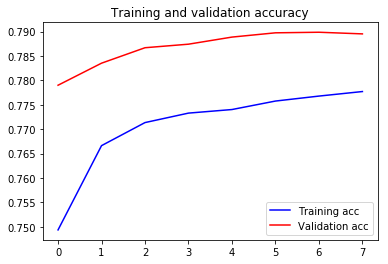

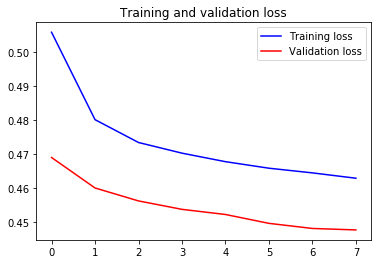

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.971221387386322,
 'elapsed_time': 0.40209317207336426}

In [38]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.009068075567483902,
 'elapsed_time': 0.23772883415222168}

In [39]:
predict("He is sad")

{'label': 'NEGATIVE',
 'score': 0.003486005589365959,
 'elapsed_time': 0.23566746711730957}

In [40]:
predict("is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!")

{'label': 'NEGATIVE',
 'score': 0.03035273402929306,
 'elapsed_time': 0.237990140914917}

### Confusion Matrix

In [41]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 66s 206us/step
CPU times: user 23.7 s, sys: 3.78 s, total: 27.5 s
Wall time: 1min 6s


In [42]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

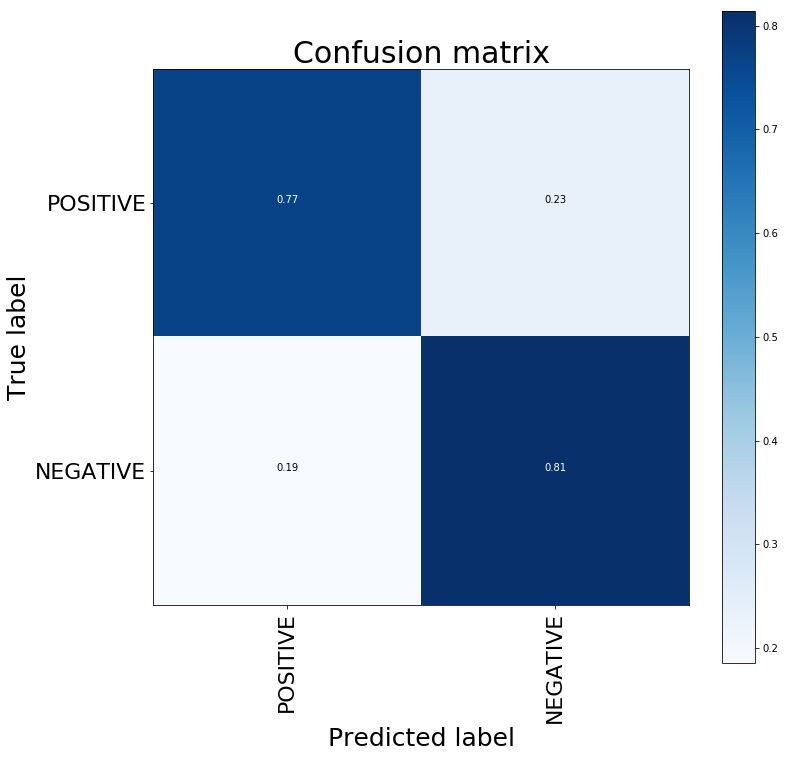

CPU times: user 1.38 s, sys: 244 ms, total: 1.62 s
Wall time: 1.35 s


In [43]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [44]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.77      0.78    159494
    POSITIVE       0.78      0.81      0.80    160506

   micro avg       0.79      0.79      0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [45]:
accuracy_score(y_test_1d, y_pred_1d)

0.79043125

### Save model

In [46]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2019-02-17 07:22:32,864 : INFO : saving Word2Vec object under model.w2v, separately None
2019-02-17 07:22:32,866 : INFO : not storing attribute vectors_norm
2019-02-17 07:22:32,867 : INFO : not storing attribute cum_table
2019-02-17 07:22:33,738 : INFO : saved model.w2v
